In [74]:
# Import necessary libraries
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner
from scipy.stats import uniform

In [75]:
# Load the training data
train_data = pd.read_csv('data/train_energy.csv')

# Convert DateTime column to datetime type
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

# Display the first few rows of the training data
train_data.head()

,DateTime,EnergyConsumption(kWh)
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9


In [76]:
# Feature engineering: Add additional features
train_data['hour'] = train_data['DateTime'].dt.hour
train_data['day_of_week'] = train_data['DateTime'].dt.dayofweek
train_data['month'] = train_data['DateTime'].dt.month

In [77]:
# Preprocess the data for Prophet
# Rename columns to 'ds' for DateTime and 'y' for the target variable
train_data.rename(columns={'DateTime': 'ds', 'EnergyConsumption(kWh)': 'y'}, inplace=True)

# Split the data into training and validation sets based on time
cutoff_date = '2016-12-01'  # Example cutoff date
train = train_data[train_data['ds'] < cutoff_date]
val = train_data[train_data['ds'] >= cutoff_date]

print('Training set:', train.shape)
print('Validation set:', val.shape)


Training set: (9504, 5)
Validation set: (745, 5)


In [78]:
# param_space = {
#     'growth': ['linear', 'logistic', 'flat'],
#     'n_changepoints': list(range(0, 55, 5)),
#     'x': uniform(0.5, 0.5),  # Define x using scipy.stats.uniform
#     'yearly_seasonality': [True, False],
#     'weekly_seasonality': [True, False],
#     'daily_seasonality': [True, False],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'seasonality_prior_scale': uniform(5.0, 15.0),  # Define ranges
#     'changepoint_prior_scale': uniform(0.0, 0.1),  # Define ranges
#     'interval_width': uniform(0.2, 0.8),  # Define ranges
#     'uncertainty_samples': [500, 1000, 1500, 2000]
# }

# def objective(params_batch):
#     results = []
#     for params in params_batch:
#         param_dict = dict(zip(param_space.keys(), params))
        
#         # Validate and constrain parameters as necessary
#         param_dict['x'] = max(0.5, min(1.0, param_dict['x']))
#         param_dict['seasonality_prior_scale'] = max(5.0, min(20.0, param_dict['seasonality_prior_scale']))
#         param_dict['changepoint_prior_scale'] = max(0.0, min(0.1, param_dict['changepoint_prior_scale']))
#         param_dict['interval_width'] = max(0.2, min(1.0, param_dict['interval_width']))
        
#         # Initialize the Prophet model
#         try:
#             model = Prophet(
#                 growth=param_dict['growth'],
#                 n_changepoints=param_dict['n_changepoints'],
#                 changepoint_range=param_dict['x'],
#                 yearly_seasonality=param_dict['yearly_seasonality'],
#                 weekly_seasonality=param_dict['weekly_seasonality'],
#                 daily_seasonality=param_dict['daily_seasonality'],
#                 seasonality_mode=param_dict['seasonality_mode'],
#                 seasonality_prior_scale=param_dict['seasonality_prior_scale'],
#                 changepoint_prior_scale=param_dict['changepoint_prior_scale'],
#                 interval_width=param_dict['interval_width'],
#                 uncertainty_samples=param_dict['uncertainty_samples'],
#             )
            
#             model.fit(train)
#             val_forecast = model.predict(val)
#             rmse = np.sqrt(mean_squared_error(val['y'], val_forecast['yhat']))
#             results.append(rmse)
#         except Exception as e:
#             print(f"Error during optimization: {e}")
#             results.append(float('inf'))  # Penalize invalid configurations
#     return results

# conf_dict = {
#     'initial_random': 10,
#     'num_iteration': 50,
# }

# tuner = Tuner(param_space, objective, conf_dict)
# results = tuner.minimize()

# if 'best_params' in results:
#     best_params = dict(zip(param_space.keys(), results['best_params']))
#     print(f"Best Parameters: {best_params}")
# else:
#     raise ValueError("Mango tuner failed to return valid parameters.")

In [79]:
# Initialize the Prophet model
# model = Prophet()

# Initialize the Prophet model with tuned hyperparameters
# model = Prophet(
#     growth=best_params['growth'],
#     n_changepoints=best_params['n_changepoints'],
#     changepoint_range=best_params['changepoint_range'],
#     yearly_seasonality=best_params['yearly_seasonality'],
#     weekly_seasonality=best_params['weekly_seasonality'],
#     daily_seasonality=best_params['daily_seasonality'],
#     seasonality_mode=best_params['seasonality_mode'],
#     seasonality_prior_scale=best_params['seasonality_prior_scale'],
#     changepoint_prior_scale=best_params['changepoint_prior_scale'],
#     interval_width=best_params['interval_width'],
#     uncertainty_samples=best_params['uncertainty_samples']
# )


# Best Parameters: {'changepoint_prior_scale': 0.002656401744611492, 'seasonality_prior_scale': 3.593142936304888}
model = Prophet(
    changepoint_prior_scale=0.002656401744611492,
    seasonality_prior_scale=3.593142936304888,
    yearly_seasonality=True,
)

# Add additional regressors
model.add_regressor('hour')
model.add_regressor('day_of_week')
model.add_regressor('month')

# Fit the model on the training data
model.fit(train)

05:53:53 - cmdstanpy - INFO - Chain [1] start processing
05:53:54 - cmdstanpy - INFO - Chain [1] done processing


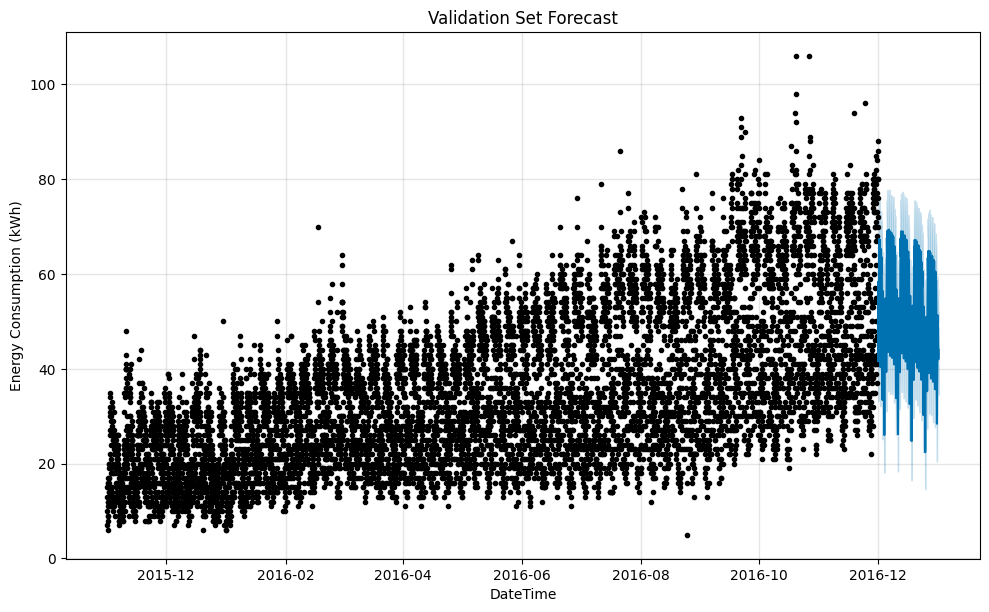

Validation RMSE: 9.400811872811387


In [80]:
# Validate the model on the validation set
val_forecast = model.predict(val)

# Visualize the forecast on the validation set
fig = model.plot(val_forecast)
plt.title('Validation Set Forecast')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

# Calculate RMSE on the validation set
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(val['y'], val_forecast['yhat']))
print(f'Validation RMSE: {rmse}')

In [81]:
# Load the test data
test_data = pd.read_csv('data/test_energy.csv')

# Convert DateTime column to datetime type
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

# Feature engineering: Add additional features
test_data['hour'] = test_data['DateTime'].dt.hour
test_data['day_of_week'] = test_data['DateTime'].dt.dayofweek
test_data['month'] = test_data['DateTime'].dt.month

# Preprocess the test data
# Rename the 'DateTime' column to 'ds'
test_data.rename(columns={'DateTime': 'ds'}, inplace=True)

# Make predictions on the test data
forecast = model.predict(test_data)

In [82]:
# Prepare the submission file
# Create a DataFrame with 'DateTime' and predicted 'EnergyConsumption(kWh)'
submission = test_data[['ds']].copy()
submission['EnergyConsumption(kWh)'] = forecast['yhat']
submission.rename(columns={'ds': 'DateTime'}, inplace=True)

# Save the submission file
submission.to_csv('prophet_submission.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())

             DateTime  EnergyConsumption(kWh)
0 2017-01-01 01:00:00               39.256448
1 2017-01-01 02:00:00               34.491692
2 2017-01-01 03:00:00               30.604836
3 2017-01-01 04:00:00               28.056892
4 2017-01-01 05:00:00               26.927884
